In [1]:
import sys
sys.path.append('..')
sys.path.append('../src')
sys.path.append('../data')

import torch
import plotly.express as px
import src.nanda_plot
from src.model import WrapHookedTransformer
from src.nanda_plot import imshow_reversed, imshow
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

In [208]:
model.cfg.device

'cpu'

In [3]:
import torch as th
from tuned_lens.plotting import PredictionTrajectory
from tuned_lens.nn import TunedLens, Unembed, LogitLens
import transformer_lens as tl
from src.model import WrapHookedTransformer

model = WrapHookedTransformer.from_pretrained(
    "gpt2",
    device="cpu",
    fold_ln=False, # The tuned lens applies the final layer norm so we should not fold
    # this into the unembed operation.
)
assert model.tokenizer is not None


tuned_lens = TunedLens.from_unembed_and_pretrained(
    unembed=Unembed(model),
    lens_resource_id="gpt2",
)

logit_lens = LogitLens.from_model(model)

def to_targets(input_ids: th.Tensor):
    return th.cat(
        (input_ids[..., 1:], th.full(input_ids.shape[:-1] + (1,), model.tokenizer.eos_token_id)
    ), dim=-1)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [226]:
from src.dataset import Dataset
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("cp")

mem_dataset lenght: 50
cp_dataset lenght: 50


In [43]:
from src.dataset import Dataset
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("mem")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_mem = model.to_tokens(batch["premise"])
targets_mem = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_mem = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():
    logits, cache = model.run_with_cache(
        input=input_ids_mem, return_type="logits"
    )

    pred_traj_clean_mem = PredictionTrajectory.from_lens_and_cache(
        lens=tuned_lens,
        cache=cache,
        model_logits=logits,
        input_ids=input_ids_mem,
        residual_component="resid_mid",
        # targets=targets,
        # anti_targets=anti_targets,
    )
    
dataset = Dataset("../data/dataset_gpt2_f.json")
dataset.select_lenght(50,16)
dataset.select_dataset("cp")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)
batch = next(iter(dataloader))
input_ids_pos = model.to_tokens(batch["premise"])
targets_cp = model.to_tokens(batch["target"], prepend_bos=False)
anti_targets_cp = model.to_tokens(batch["orthogonal_token"], prepend_bos=False)
with th.inference_mode():
    logits, cache = model.run_with_cache(
        input=input_ids_pos, return_type="logits"
    )

    pred_traj_clean_cp = PredictionTrajectory.from_lens_and_cache(
        lens=tuned_lens,
        cache=cache,
        model_logits=logits,
        input_ids=input_ids_pos,
        residual_component="resid_mid",
        # targets=targets,
        # anti_targets=anti_targets,
    )



mem_dataset lenght: 50
cp_dataset lenght: 50
mem_dataset lenght: 50
cp_dataset lenght: 50


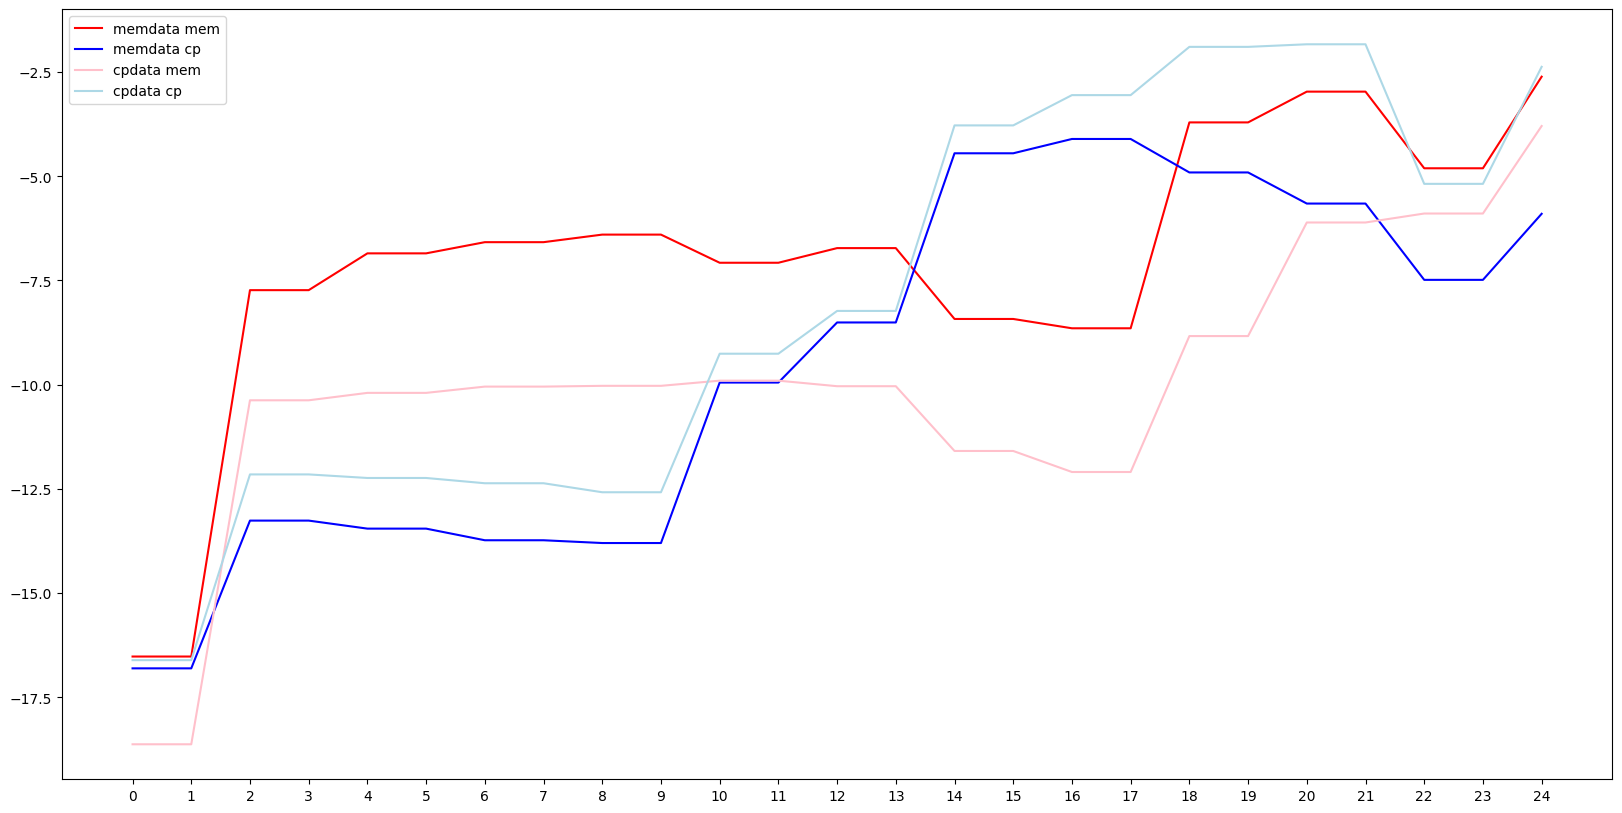

In [18]:
POS = -1

logit_mem = pred_traj_clean_mem.log_probs[:,:,POS,:]
logit_target_mem =  torch.gather(torch.tensor(logit_mem), 2, targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_mem = torch.gather(torch.tensor(logit_mem), 2, anti_targets_mem.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()


logit_cp = pred_traj_clean_cp.log_probs[:,:,POS,:]
logit_target_cp =  torch.gather(torch.tensor(logit_cp), 2, targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()
logit_anti_target_cp = torch.gather(torch.tensor(logit_cp), 2, anti_targets_cp.unsqueeze(1).expand(-1, 25, -1)).squeeze(-1).detach().numpy()

#plot 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#plot line plot
plt.figure(figsize=(20,10))
plt.plot(logit_target_mem.mean(0), label="memdata mem", color="red")
# add variance
# plt.fill_between(np.arange(13), logit_target.mean(0) - logit_target.std(0), logit_target.mean(0) + logit_target.std(0), alpha=0.3)
plt.plot(logit_anti_target_mem.mean(0), label="memdata cp", color="blue")
plt.plot(logit_target_cp.mean(0), label="cpdata mem", color="pink")
plt.plot(logit_anti_target_cp.mean(0), label="cpdata cp", color="lightblue")
# plt.fill_between(np.arange(13), logit_anti_target.mean(0) - logit_anti_target.std(0), logit_anti_target.mean(0) + logit_anti_target.std(0), alpha=0.3)
plt.xticks(np.arange(25))
plt.legend()

In [11]:
import circuitsvis as cv
model = WrapHookedTransformer.from_pretrained(
    "gpt2",
    device="cpu",
    fold_ln=False, # The tuned lens applies the final layer norm so we should not fold
    # this into the unembed operation.
)
logit, cache = model.run_with_cache(
    "Indonesia's capital,hani Indonesia's capital,"
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [258]:
cache["pattern",1].shape

torch.Size([1, 12, 12, 12])

In [105]:
logit, cache = model.run_with_cache(
    "Windows 98, a product developed bytest Windows 98, a product developed by"
)
cv.attention.attention_patterns(attention=cache["pattern",11][0], tokens=model.to_str_tokens("Windows 98, a product developed bytest Windows 98, a product developed by"))

In [102]:
logit, cache = model.run_with_cache(
    "Finnish Democratic Republic's capital,ostic Finnish Democratic Republic's capital,"
)
cv.attention.attention_patterns(attention=cache["pattern",7][0], tokens=model.to_str_tokens("Android is created byAl Android is created by"))

In [91]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [96]:
cache["attn",0,"out"].shape

torch.Size([50, 12, 16, 16])

In [77]:
(cache["attn",0][:,:,15,8] @ cache["attn", 0, "v"][:,:,15,8].T) @ model.W_O[]

tensor([[0.0157, 0.0113, 0.0199,  ..., 0.0185, 0.0090, 0.0264],
        [0.0113, 0.5136, 0.0257,  ..., 0.0304, 0.0125, 0.0186],
        [0.0199, 0.0257, 0.0341,  ..., 0.0330, 0.0132, 0.0366],
        ...,
        [0.0185, 0.0304, 0.0330,  ..., 0.0343, 0.0131, 0.0337],
        [0.0090, 0.0125, 0.0132,  ..., 0.0131, 0.0061, 0.0151],
        [0.0264, 0.0186, 0.0366,  ..., 0.0337, 0.0151, 0.0465]])

In [75]:
cache["attn", 0, "v"][:,:,15,8]

torch.Size([50, 12])

In [67]:
cache["attn",0][:,:,15,8] cache["resid_pre", 0][:,-1,:]

torch.Size([50, 768])

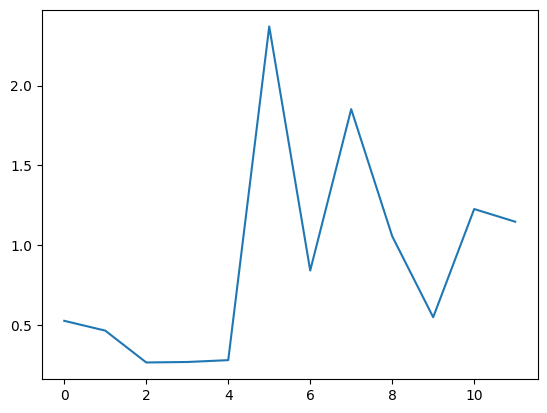

In [88]:
logit, cache = model.run_with_cache(
    input_ids_mem
)

result = torch.zeros(input_ids.shape[0], 12)
result_subj = torch.zeros(input_ids.shape[0], 12)
cache["attn",1][:,:,15,8].sum(1)
for layer in range(12):
    result[:,layer] = cache["attn",layer,"out"][:,:,15,8].sum(1)
    # result_subj[:,layer] = (cache["attn",layer][:,:,15,1].sum(1) + cache["attn",layer][:,:,15,9].sum(1))/2
plt.plot(result.detach().numpy().mean(0))
# plt.plot(result_subj.detach().numpy().mean(0))

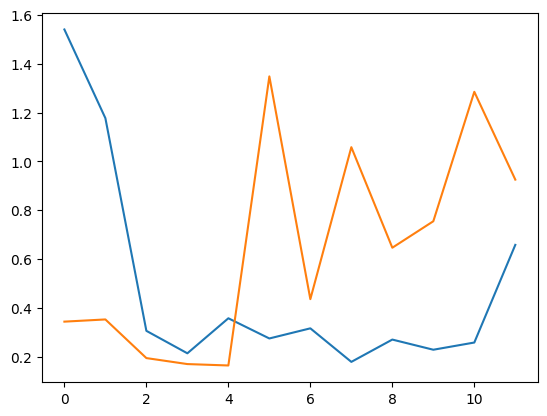

In [56]:
logit, cache = model.run_with_cache(
    input_ids_pos
)
result = torch.zeros(input_ids_pos.shape[0], 12)
cache["attn",1][:,:,15,8].sum(1)
for layer in range(12):
    result[:,layer] = cache["attn",layer][:,:,15,8].sum(1)
    result_subj[:,layer] = (cache["attn",layer][:,:,15,1].sum(1) + cache["attn",layer][:,:,15,9].sum(1))/2
plt.plot(result.detach().numpy().mean(0))
plt.plot(result_subj.detach().numpy().mean(0))
